<img src="IMG/dask_horizontal.svg"  width="30%">

## AI Systems SS25
#### Janis Keuper


<img src="IMG/dask_horizontal.svg"  width="10%">


# Introduction to DASK
* Dask is a parallel computing library that scales the existing Python ecosystem. 
* Dask can scale down to your laptop laptop and up to a cluster.

   
## DASK Ressources 
*  [DASK Website](http://dask.org)
*  [Documentation](https://dask.pydata.org/en/latest/)


## DASK in the Python Eco System

<img src="IMG/python-stack.png" width=80%>

https://jupytearth.org/jupyter-resources/introduction/ecosystem.html

<img src="IMG/dask_horizontal.svg"  width="10%">

## Key Features of DASK

*  **High level Interface:**  Dask provides high-level Array, Bag, and DataFrame
   collections that mimic NumPy, lists, and Pandas but can operate in parallel on
   datasets that don't fit into memory.  Dask's high-level collections are
   alternatives to NumPy and Pandas for large datasets.

*  **Low Level Interface:** Dask provides dynamic task schedulers that
   execute task graphs in parallel.  These execution engines power the
   high-level collections mentioned above but can also power custom,
   user-defined workloads.  These schedulers are low-latency (around 1ms) and
   work hard to run computations in a small memory footprint.  Dask's
   schedulers are an alternative to direct use of `threading` or
   `multiprocessing` libraries in complex cases or other task scheduling
   systems like `Luigi` or `IPython parallel`.

<img src="IMG/dask_horizontal.svg"  width="10%">

## DASK Scalability 

### runs on single node (your laptop!)
* multi-core parallelization 
* hardly any overhead

### scales to large clusters with thausands of nodes
* with the ***SAME*** code as on the laptop




<img src="IMG/dask_horizontal.svg"  width="10%">

### Worker ressource management 
* max memory, CPU cores
* GPU assignment 

### Large Memory support
* allows out of Memory processing of large data even on single node

<img src="IMG/dask_horizontal.svg"  width="10%">

## DASK-ML
* Scikit-Learn like API for Machine Learning

## Large Scale Data Visualization
* With DataShader

# High Level Interfaces: Parallelizing NumPy and Pandas

<img src="IMG/numpy.png"  width="10%">

## Dask Arrays: Distributed NumPy

* Arithmetic and scalar mathematics: +, *, exp, log, ...
* Reductions along axes: sum(), mean(), std(), sum(axis=0), ...
* Tensor contractions / dot products / matrix multiply: tensordot
* Axis reordering / transpose: transpose
* Slicing: x[:100, 500:100:-2]
* Fancy indexing along single axes with lists or NumPy arrays: x[:, [10, 1, 5]]
* Array protocols like __array__ and __array_ufunc__
* Some linear algebra: svd, qr, solve, solve_triangular, lstsq

**Full Array API: https://docs.dask.org/en/latest/array-api.html**

<img src="IMG/numpy.png"  width="10%">

### Limitations

* Much of np.linalg has not been implemented. This has been done by a number of excellent BLAS/LAPACK implementations, and is the focus of numerous ongoing academic research projects
* Arrays with unknown shapes do not support all operations
* Operations like sort which are notoriously difficult to do in parallel, and are of somewhat diminished value on very large data (you rarely actually need a full sort). Often we include parallel-friendly alternatives like topk
* Dask Array doesn’t implement operations like tolist that would be very inefficient for larger datasets. Likewise, it is very inefficient to iterate over a Dask array with for loops
  
**DASK is still evolving ...**

## Just get started!

In [1]:
#uncomment on first run
#!pip install distributed "dask[complete]" dask-ml graphviz numpy==1.24.3 -q --ignore-installed

In [2]:
#let's parallelize a simple array opperations
import numpy as np
np_A = np.random.rand(10000,10000) #create random NumPy array
%time np_A.sum()

CPU times: user 41.6 ms, sys: 42 μs, total: 41.7 ms
Wall time: 41.7 ms


np.float64(50003881.036777504)

In [3]:
#now in parallel 
import dask.array as da
da_A = da.from_array(np_A, chunks=(5000)) #create DASk array from existing NumPy array
res = da_A.sum() #tell dask to compute the sum of A

In [4]:
res

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

### Where is my result?
In a nutshell: ***DASK*** basically works like ***TensorFlow***:
* First, it builds an execution graph
* Then, we need to execute it by calling ``compute()``

In [5]:
#call compute
%time res.compute()

CPU times: user 271 ms, sys: 13.8 ms, total: 285 ms
Wall time: 236 ms


np.float64(50003881.03677731)

### Why is this not faster?
Well, building the graph, parallelizing it and scheduling it's execution causes some overhead...
* probably, our problem was to small :-)


### What is happening at ``compute()`` ?


In [6]:
!pip install -q graphviz

In [7]:
#have look at the actual compute graph build by DASK
_=res.visualize(filename='IMG/graph.svg')

<img src="IMG/graph.svg" width=200>

### Ahh - MapReduce!
* looks like ***DASK*** automatically implemented MapReduce
* but, why did it use 4 parallel paths?

<img src="IMG/graph.svg" width=150>

### Block concept of DASK arrays
* ***DASK*** splitts arrays into blocks 
* parallelization (here MapReduce) runs over Blocks
* Blocks sizes are definde by the ``chunks`` 

```
#recall array creation
da_A = da.from_array(np_A, chunks=(5000))
```

<img SRC="IMG/array.png">

In [8]:
#get size of chucks
da_A.chunks

((5000, 5000), (5000, 5000))

In [9]:
da_A.chunksize

(5000, 5000)

In [10]:
#change chunk size
#WARNING: can be very expensive - better think about the chunk size before ...
B=da_A.rechunk(1000)

In [11]:
B.chunks

((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000),
 (1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000))

In [12]:
res=B.sum()
graph=res.visualize(filename='IMG/graph2.svg')#saving graph to file

<img src="IMG/graph2.svg" >

### Is this running in Parallel ?
* open ternminal
* start ``top``
* execute ``compute()``

In [13]:
%%timeit #measure mean of 10 runs
res.compute()

202 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Memory Usage
By processing each block at a time, ***DASK*** is not only able tu run in parallel, but also needs only tthe memory for the bock size...
* allows easy processing of **larger than memory** data sets

In [14]:
#a larger example in NumPy
%time x = np.random.normal(10, 0.1, size=(20000, 20000)) 
%time y = x.mean(axis=0) #compute mean along first axis


CPU times: user 5.5 s, sys: 1.02 s, total: 6.52 s
Wall time: 6.52 s
CPU times: user 205 ms, sys: 0 ns, total: 205 ms
Wall time: 204 ms


In [15]:
#same in DASK
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0) 
%time res=y.compute() 

CPU times: user 10.5 s, sys: 24.1 ms, total: 10.6 s
Wall time: 988 ms


<img src="IMG/pandas_logo.png"  width="20%">

## DASK DataFrames: Dirstributed Pandas
Pandas Dataframes are a very popular tool that provide full speadsheet and in-memory database functionality for the ***Python*** ecco system. It has become one of tstandard tools in Data Science and is also widely used for pre-processing / data wrangling tasks in machine learning

* the ***DASK*** API for ***Pandas*** is analog to the one for ***NumPy*** and will not be discussed here, see https://docs.dask.org/en/latest/dataframe.html for details.

In [16]:
# first example
import dask.dataframe as dd
import dask
df = dask.datasets.timeseries()


In [17]:
df

,name,id,x,y
npartitions=30,,,,
2000-01-01,string,int64,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


Recall: ***lazy*** execution! No data in dataframe at this time...

In [18]:
#this is a call
df.head()

,name,id,x,y
timestamp,,,,
2000-01-01 00:00:00,Sarah,982,-0.724104,-0.379251
2000-01-01 00:00:01,Wendy,1049,0.560341,0.458483
2000-01-01 00:00:02,Tim,1005,0.527510,0.206053
2000-01-01 00:00:03,Patricia,998,-0.747706,0.018709
2000-01-01 00:00:04,Ingrid,1027,0.216105,0.992261


In [19]:
#let's groupBy ...
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 8 expressions
Expr=(((Filter(frame=ArrowStringConversion(frame=Timeseries(237d26c)), predicate=ArrowStringConversion(frame=Timeseries(237d26c))['y'] > 0))[['name', 'x']]).std(ddof=1, numeric_only=False, split_out=None, observed=False))['x']

In [20]:
df3.compute()


name
Bob         0.577790
Dan         0.577095
Edith       0.576823
George      0.576427
Hannah      0.578984
Ingrid      0.578480
Laura       0.578101
Michael     0.575928
Quinn       0.578986
Ray         0.577553
Sarah       0.578545
Wendy       0.577211
Yvonne      0.577393
Zelda       0.578452
Alice       0.577562
Charlie     0.577180
Frank       0.577095
Jerry       0.576082
Kevin       0.580681
Norbert     0.577490
Oliver      0.578097
Patricia    0.575259
Tim         0.577527
Ursula      0.576644
Victor      0.577710
Xavier      0.576871
Name: x, dtype: float64

In [21]:
#more complex opperation -> need trigger to start computation!
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-0.012378,0.029680
2000-01-01 01:00:00,0.005484,0.006413
2000-01-01 02:00:00,-0.013050,-0.014023
2000-01-01 03:00:00,-0.014303,0.010828
2000-01-01 04:00:00,0.013485,-0.001830


<Axes: xlabel='timestamp'>

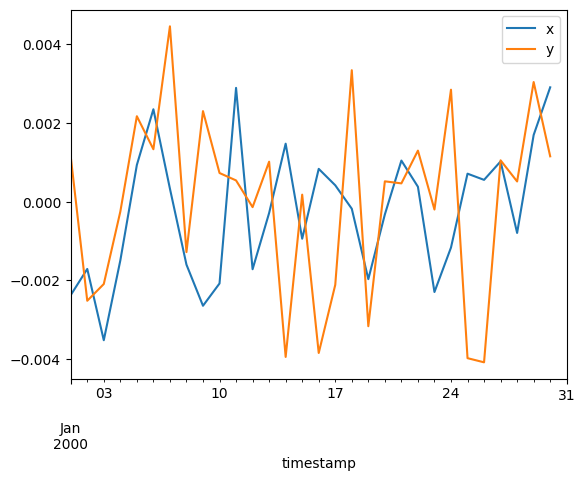

In [22]:
df[['x', 'y']].resample('24h').mean().compute().plot()

### DASK DataFrame summary
* almost identical API as Pandas -> some thigs are still missing!
* out of memory opperations
* lazy execution -> need to trigger results via *atomic* opperations (just like in Spark)


# Distributed Execution

In [23]:
#create local cluster with CPU Cores
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In our cluster enviroment, the ***DASK*** Cluster is automatically started for multi node jobs. See DASK documentation on how to setup a ***DASK*** cluster: http://distributed.dask.org/en/latest/setup.html

In [24]:
#client = Client(MASTER-IP) #get new DASK cluster client

In [25]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41319,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43331,Total threads: 3
Dashboard: http://127.0.0.1:38923/status,Memory: 3.82 GiB
Nanny: tcp://127.0.0.1:41193,


In [26]:
#see how many workers we have
workers=client.scheduler_info()['workers']
for w in workers:
    print(w)

tcp://127.0.0.1:37869
tcp://127.0.0.1:40977
tcp://127.0.0.1:42025
tcp://127.0.0.1:43331


## Submit work to the Cluster

In [27]:
#simple remote functions
def square(x):
    return x ** 2

def neg(x):
    return -x

#using the map future, functions will be scheduled for execution - NO graph building and compute()
A = client.map(square, range(1000))
B = client.map(neg, A)

In [28]:
total = client.submit(sum, B)

In [29]:

res = total.result()
print ("done: ",res)

done:  -332833500


### Arrays on the Cluster
Starting a cluster client automatically cause the high level interfaces to use the cluster

In [30]:
import numpy as np
np_A = np.random.rand(10000,10000) #create random NumPy array
import dask.array as da
cluster_A = da.from_array(np_A, chunks=(5000)) #create DASk array from existing NumPy array
res = cluster_A.sum() #tell dask to compute the sum of A

In [31]:

%time res.compute()

/home/keuper/anaconda3/envs/dask/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 720 ms, sys: 1.15 s, total: 1.87 s
Wall time: 2.24 s


np.float64(50003321.054577164)

## Dask Dashboard

* Open http://localhost:8787/status to get the Dask dashboard 
* (replace with master node IP for remote clusters)

## ***DASK-ML*** Project
Approach to make ***DASK*** a full distributed ML framework
* https://ml.dask.org/
* Scikit-Learn like API: https://ml.dask.org/modules/api.html

In [32]:
#!pip install -q dask-ml 

### Example: K-MEANS

In [33]:
%matplotlib inline

import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt



In [36]:
#generate like in execise 2, but now with dask_mL
X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist() #manual executions on X
X

dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

In [37]:
#call skleran k-means
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2000, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2000, n_clusters=3, oversampling_factor=10)

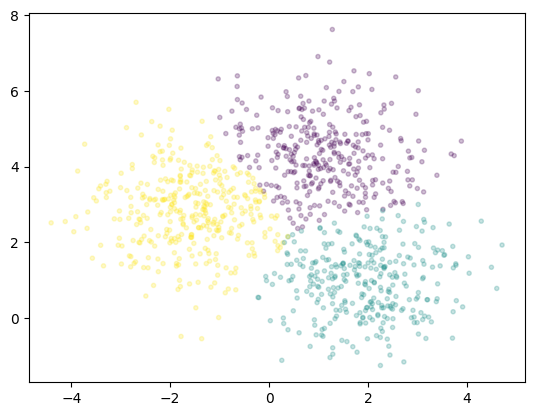

In [38]:
plt.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000],  cmap='viridis', alpha=0.25);



### Example: Hyper-parameter optimization

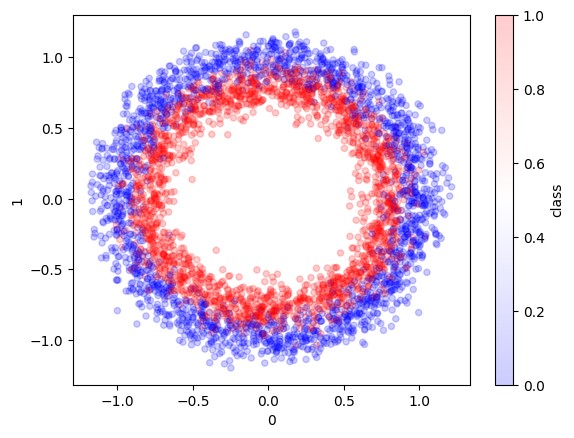

In [39]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X, y = make_circles(n_samples=30_000, random_state=0, noise=0.09)

pd.DataFrame({0: X[:, 0], 1: X[:, 1], "class": y}).sample(4_000).plot.scatter(
    x=0, y=1, alpha=0.2, c="class", cmap="bwr"
);

In [40]:
# make date 6D to get larger problem
from sklearn.utils import check_random_state

rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X.shape[0], 4))
X = np.hstack((X, random_feats))
X.shape

(30000, 6)

In [41]:
#gen train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5_000, random_state=42)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [42]:
#create small NN
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}



In [43]:
from dask_ml.model_selection import HyperbandSearchCV

n_examples = 4 * len(X_train)
n_params = 8

# In practice, HyperbandSearchCV is most useful for longer searches
# n_examples = 15 * len(X_train)
# n_params = 15

In [44]:
#prepare date in chunks
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees


X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train, chunks=chunks)
X_train2

dask.array<array, shape=(25000, 6), dtype=float64, chunksize=(12500, 6), chunktype=numpy.ndarray>

In [45]:
#setup search model
search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,
)
search.metadata["partial_fit_calls"] #get number of evaluations

np.int64(26)

In [47]:
#start!
search.fit(X_train2, y_train2, classes=[0, 1, 2, 3])

RuntimeError: Attempting to use an asynchronous Client in a synchronous context of `dask.compute`

In [48]:
#get results
print(search.best_score_)
print(search.best_estimator_)



AttributeError: 'HyperbandSearchCV' object has no attribute 'best_score_'

# Low Level Interfaces: Parallelizing Compute Graphs
Building the Compute-Graph manually

In [49]:
# simple example
def inc(x):
    return x + 1

def double(x):
    return x + 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)


In [50]:
total

45

### **Now, build a graph:**
```dask.delayed()``` add functions and arguments to graph:

In [51]:
import dask

output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)


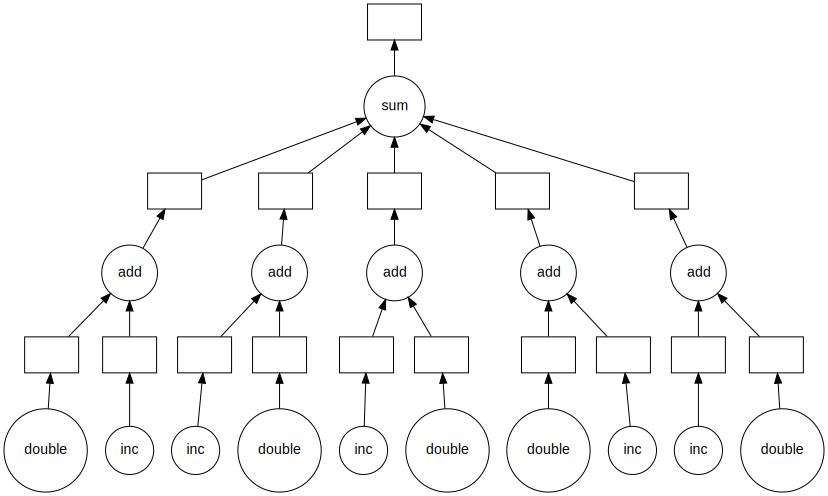

In [52]:
total.visualize(filename="graph2.svg")

In [53]:
#call copute to execute
total.compute()

45

## More in the Lab !
* and here https://github.com/dask/dask-tutorial
* and here https://livebook.manning.com/book/data-science-at-scale-with-python-and-dask/about-this-book/